# MPC COVID-19

Modelling and simulation of a COVID-19 compartmental system.

## Modelling

### Variables

| Variable       | Description                                 |
|:--------------:|:-------------------------------------------:|
| $P_k$          | Total individuals in age group $k$          |
| $S_k$          | Susceptible individuals from age group $k$  |
| $I_k$          | Infected individuals from age group $k$     |
| $R_k$          | Recovered individuals from age group $k$    |
| $D_k$          | Deceased individuals from age group $k$     |
| $U_k$          | Vaccination rate for age group $k$          |
| $\lambda_k$    | Infection rate for age group $k$            |
| $C_{j,k}$      | Contact rate between age groups $j$ and $k$ |
| $\gamma_{R,k}$ | Recovery rate for age group $k$             |
| $\gamma_{D,k}$ | Decease rate for age group $k$              |
| $n_a$          | Number of age groups                        |
| $\Delta_t$     | Sampling Period                             |

### Continous Model

$$
\left\{\begin{aligned}
\frac{d S_k(t)}{dt} &= -\lambda_k \cdot S_k(t) \cdot \sum_{j=1}^{n_a} C_{j,k} \cdot I_j(t) - U_k(t)
\\
\frac{d I_k(t)}{dt} &= \lambda_k \cdot S_k(t) \cdot \sum_{j=1}^{n_a} C_{k,j} \cdot I_j(t) - (\gamma_{R,k} + \gamma_{D,k}) \cdot I_k(t)
\\
\frac{d R_k(t)}{dt} &= \gamma_{R,k} \cdot I_k(t) + U_k(t)
\\
\frac{d D_k(t)}{dt} &= \gamma_{D,k} \cdot I_k(t)
\end{aligned}\right.
, k = 1, \dotsc, n_a
$$

### Discrete Model

$$
\left\{\begin{aligned}
S_k(n+1) &= S_k(n) + \Delta_t \cdot \left( -\lambda_k \cdot S_k(n) \cdot \sum_{j=1}^{n_a} C_{j,k} \cdot I_j(n) - U_k(n) \right)
\\
I_k(n+1) &= I_k(n) + \Delta_t \cdot \left( \lambda_k \cdot S_k(n) \cdot \sum_{j=1}^{n_a} C_{k,j} \cdot I_j(n) - (\gamma_{R,k} + \gamma_{D,k}) \cdot I_k(n) \right)
\\
R_k(n+1) &= R_k(n) + \Delta_t \cdot \left( \gamma_{R,k} \cdot I_k(n) + U_k(n) \right)
\\
D_k(n+1) &= D_k(n) + \Delta_t \cdot \left( \gamma_{D,k} \cdot I_k(n) \right)
\end{aligned}\right.
, k = 1, \dotsc, n_a
$$
Considering $\Delta_t = 1$
$$
\left\{\begin{aligned}
S_k(n+1) &= S_k(n) - \lambda_k \cdot S_k(n) \cdot \sum_{j=1}^{n_a} C_{j,k} \cdot I_j(n) - U_k(n)
\\
I_k(n+1) &= I_k(n) + \lambda_k \cdot S_k(n) \, \sum_{j=1}^{n_a} C_{k,j} \cdot I_j(n) - (\gamma_{R,k} + \gamma_{D,k}) \cdot I_k(n)
\\
R_k(n+1) &= R_k(n) + \gamma_{R,k} \cdot I_k(n) + U_k(n)
\\
D_k(n+1) &= D_k(n) + \gamma_{D,k} \cdot I_k(n)
\end{aligned}\right.
, k = 1, \dotsc, n_a
$$

## Pre-Simulation

### Definitions

In [1]:
import numpy as np
from helpers import *

P, S_0, I_0, R_0, D_0, l, C, g_R, g_D, u_max = definitions()
y_0 = wrap(S_0, I_0, R_0, D_0)
n_a = len(P)

t_span = [0, 80]

print(f'Population Total: {sum(P):.0f}')

Population Total: 3645243


## Continous Simulation

In [2]:
def system_continuous(t, y, u, u_max, l, C, g_R, g_D):
  S, I, R, D = unwrap(y)
  dSdt = - l * S * (C @ I) - u(t, y, u_max)
  dIdt = l * S * (C @ I) - (g_R + g_D) * I
  dRdt = g_R * I + u(t, y, u_max)
  dDdt = g_D * I
  return wrap(dSdt, dIdt, dRdt, dDdt)

### No Vaccination

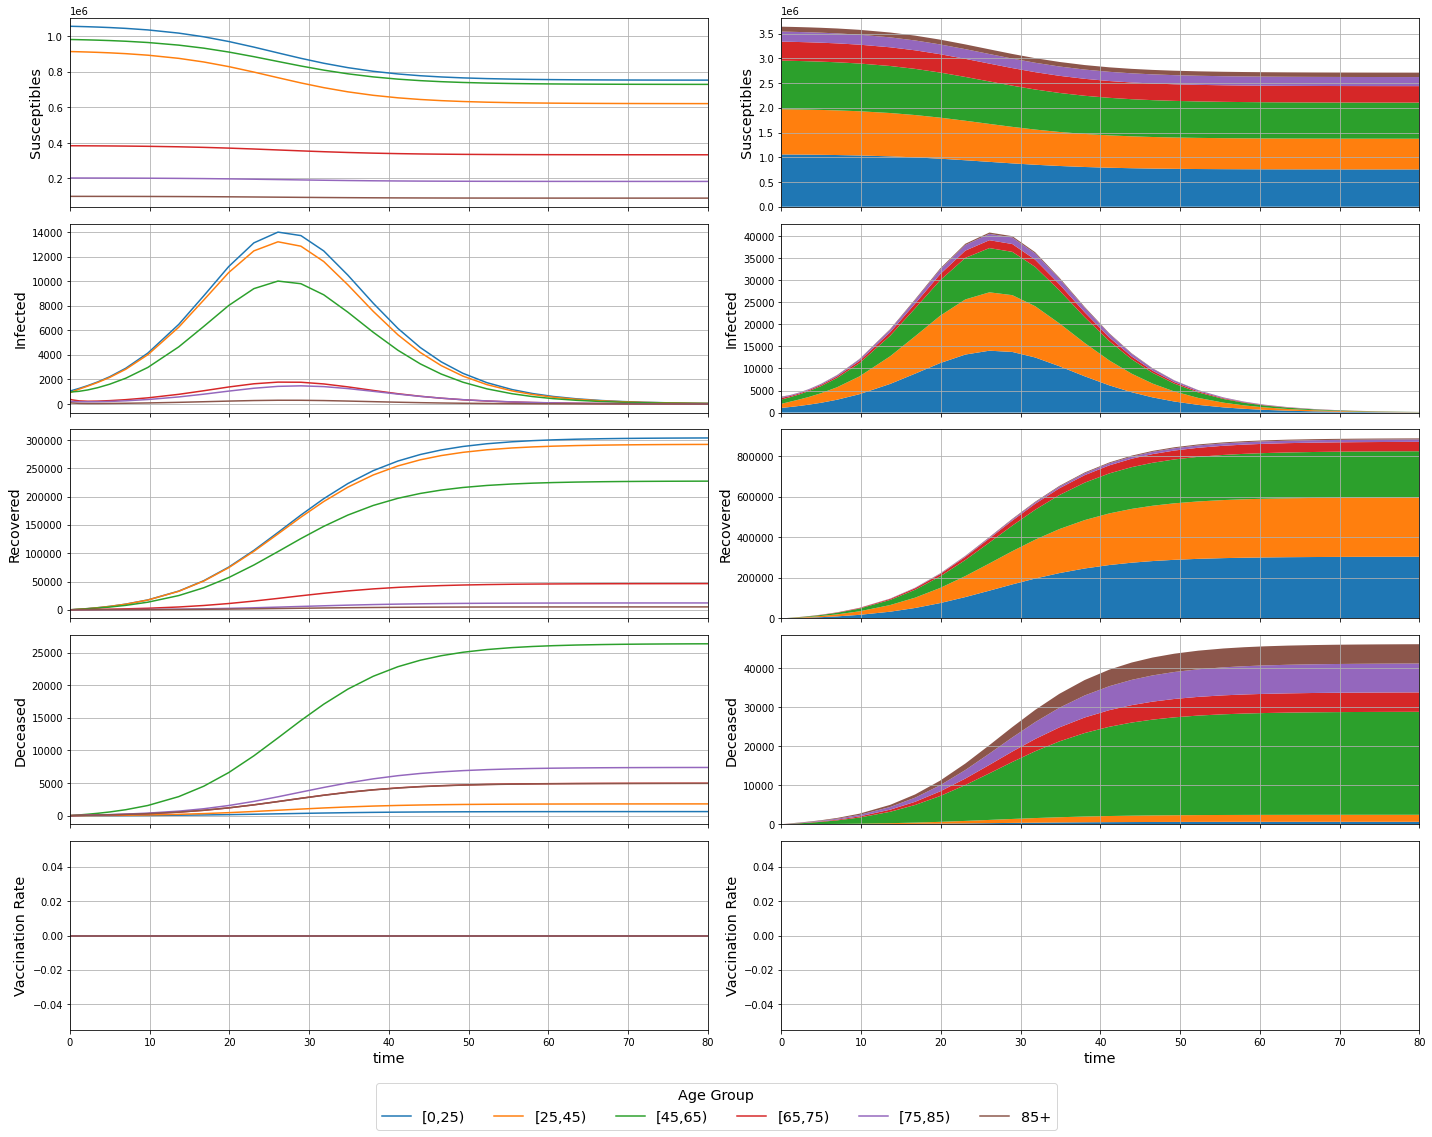

Deceased Total: 46089


In [3]:
from scipy.integrate import solve_ivp

def control(t, y, max):
  return np.zeros(n_a)

sol = solve_ivp(system_continuous, t_span, y_0, args=(control, u_max, l, C, g_R, g_D))
assert(sol.success)

t = sol.t
y = sol.y
S, I, R, D = unwrap(y)
u = recover_control(t, y, control, u_max)

plot(t, y, u)
print(f'Deceased Total: {sum(D[:,-1]):.0f}')

### Vaccination of Older Groups with Exclusivity

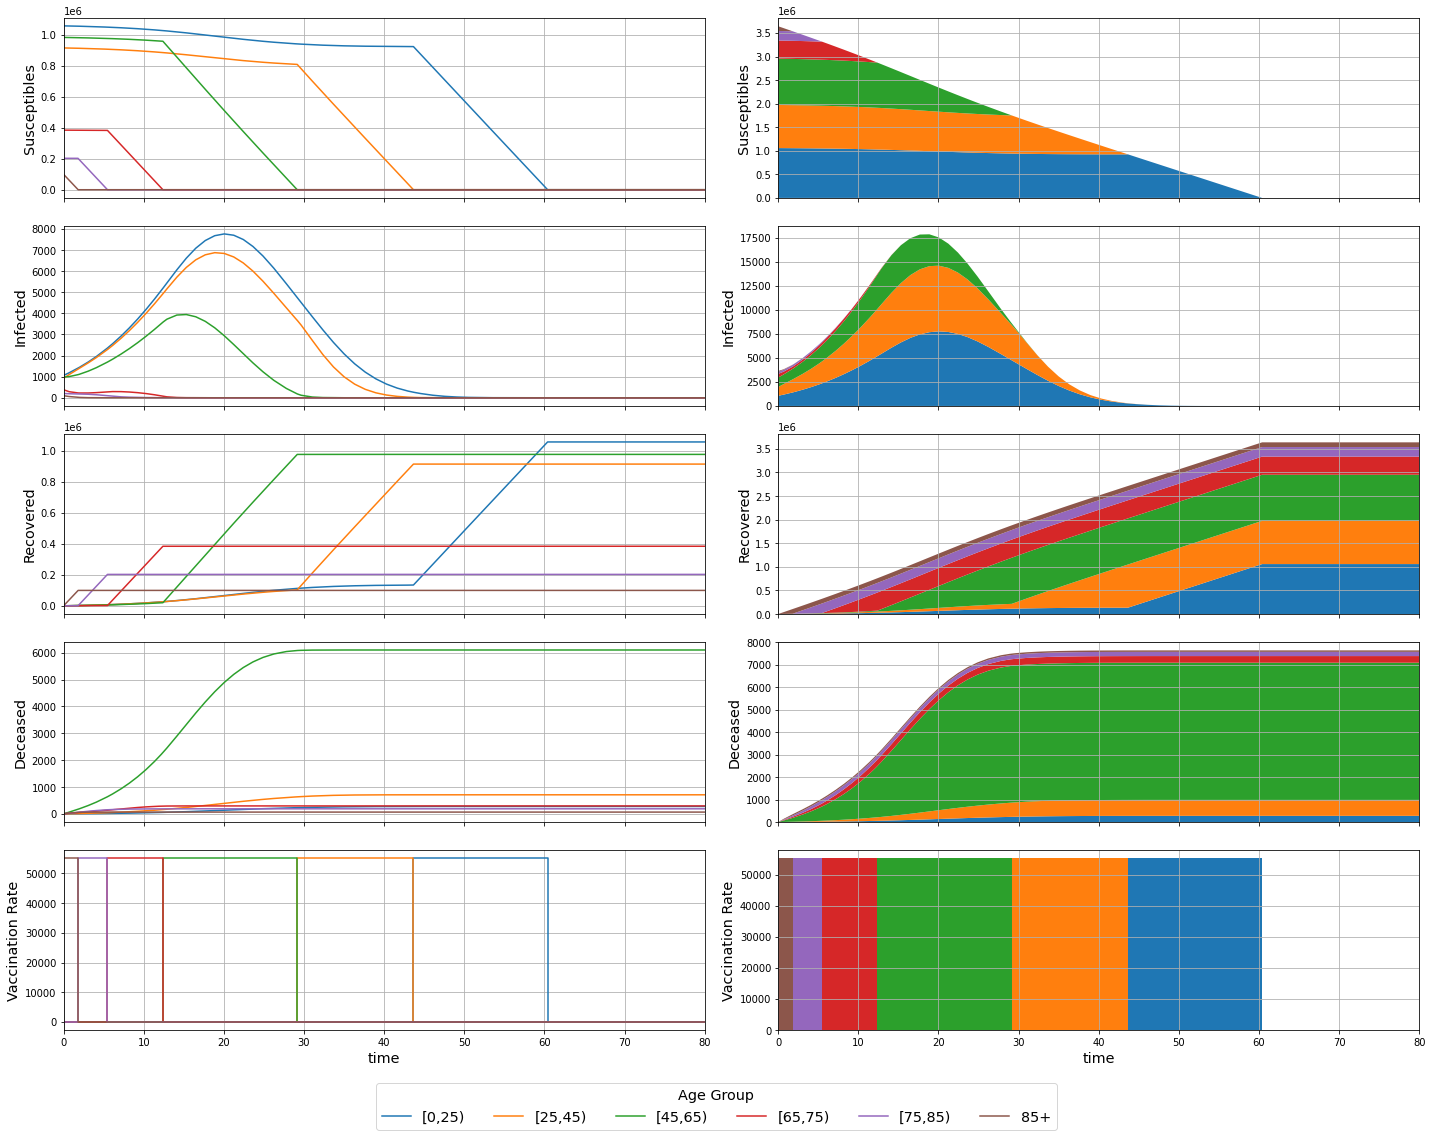

Deceased Total: 7633


In [4]:
from scipy.integrate import solve_ivp

def control(t, y, u_max):
  S, I, R, D = unwrap(y)
  u = np.zeros(n_a)
  for i in reversed(range(n_a)):
    if S[i] > 0:
      u[i] = u_max
      break
  return u

sol = solve_ivp(system_continuous, t_span, y_0, args=(control, u_max, l, C, g_R, g_D))
assert(sol.success)

t = sol.t
y = sol.y
S, I, R, D = unwrap(y)
u = recover_control(t, y, control, u_max)

plot(t, y, u)
print(f'Deceased Total: {sum(D[:,-1]):.0f}')

### Vaccination of Older Groups with Intersection

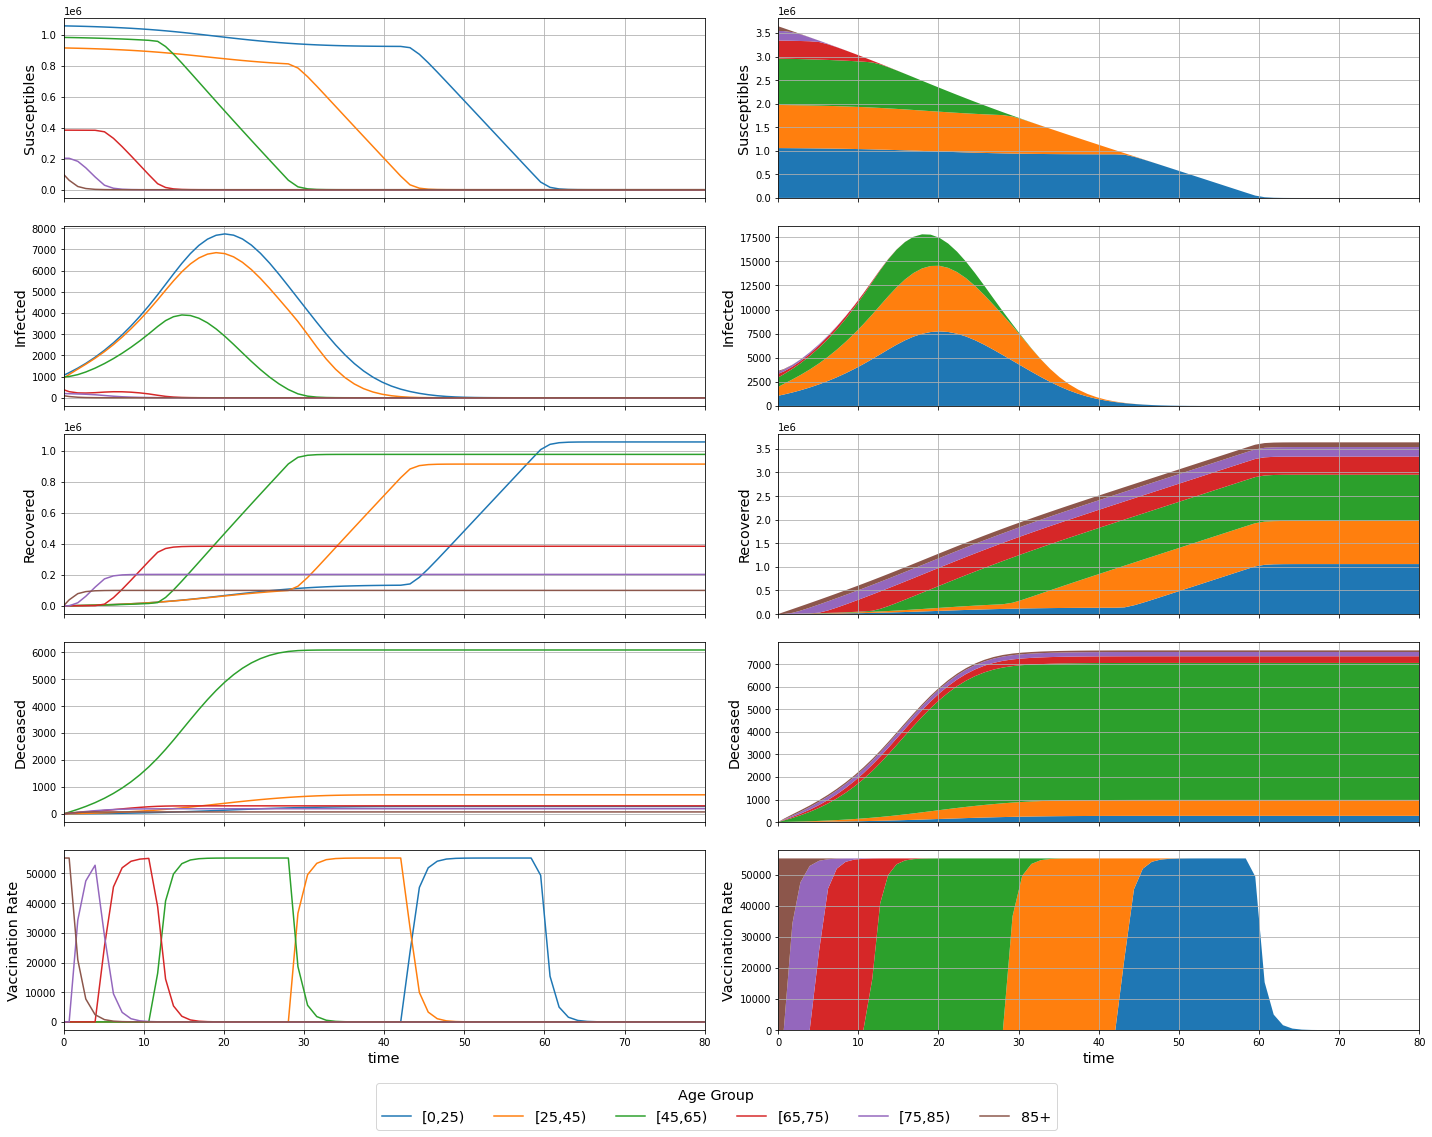

Deceased Total: 7616


In [5]:
from scipy.integrate import solve_ivp

def control(t, y, u_max):
  S, I, R, D = unwrap(y)
  u = np.zeros(n_a)
  remaining = u_max
  for i in reversed(range(n_a)):
    u[i] = min([S[i], remaining])
    remaining = remaining - u[i]
  return u

sol = solve_ivp(system_continuous, t_span, y_0, args=(control, u_max, l, C, g_R, g_D))
assert(sol.success)

t = sol.t
y = sol.y
S, I, R, D = unwrap(y)
u = recover_control(t, y, control, u_max)

plot(t, y, u)
print(f'Deceased Total: {sum(D[:,-1]):.0f}')

## Discrete Simulation

In [6]:
def system_discrete(t, y, u, u_max, l, C, g_R, g_D):
  S, I, R, D = unwrap(y)
  S_ = S - l * S * (C @ I) - u(t, y, u_max)
  I_ = I + l * S * (C @ I) - (g_R + g_D) * I
  R_ = R + g_R * I + u(t, y, u_max)
  D_ = D + g_D * I
  return wrap(S_, I_, R_, D_)

### No Vaccination

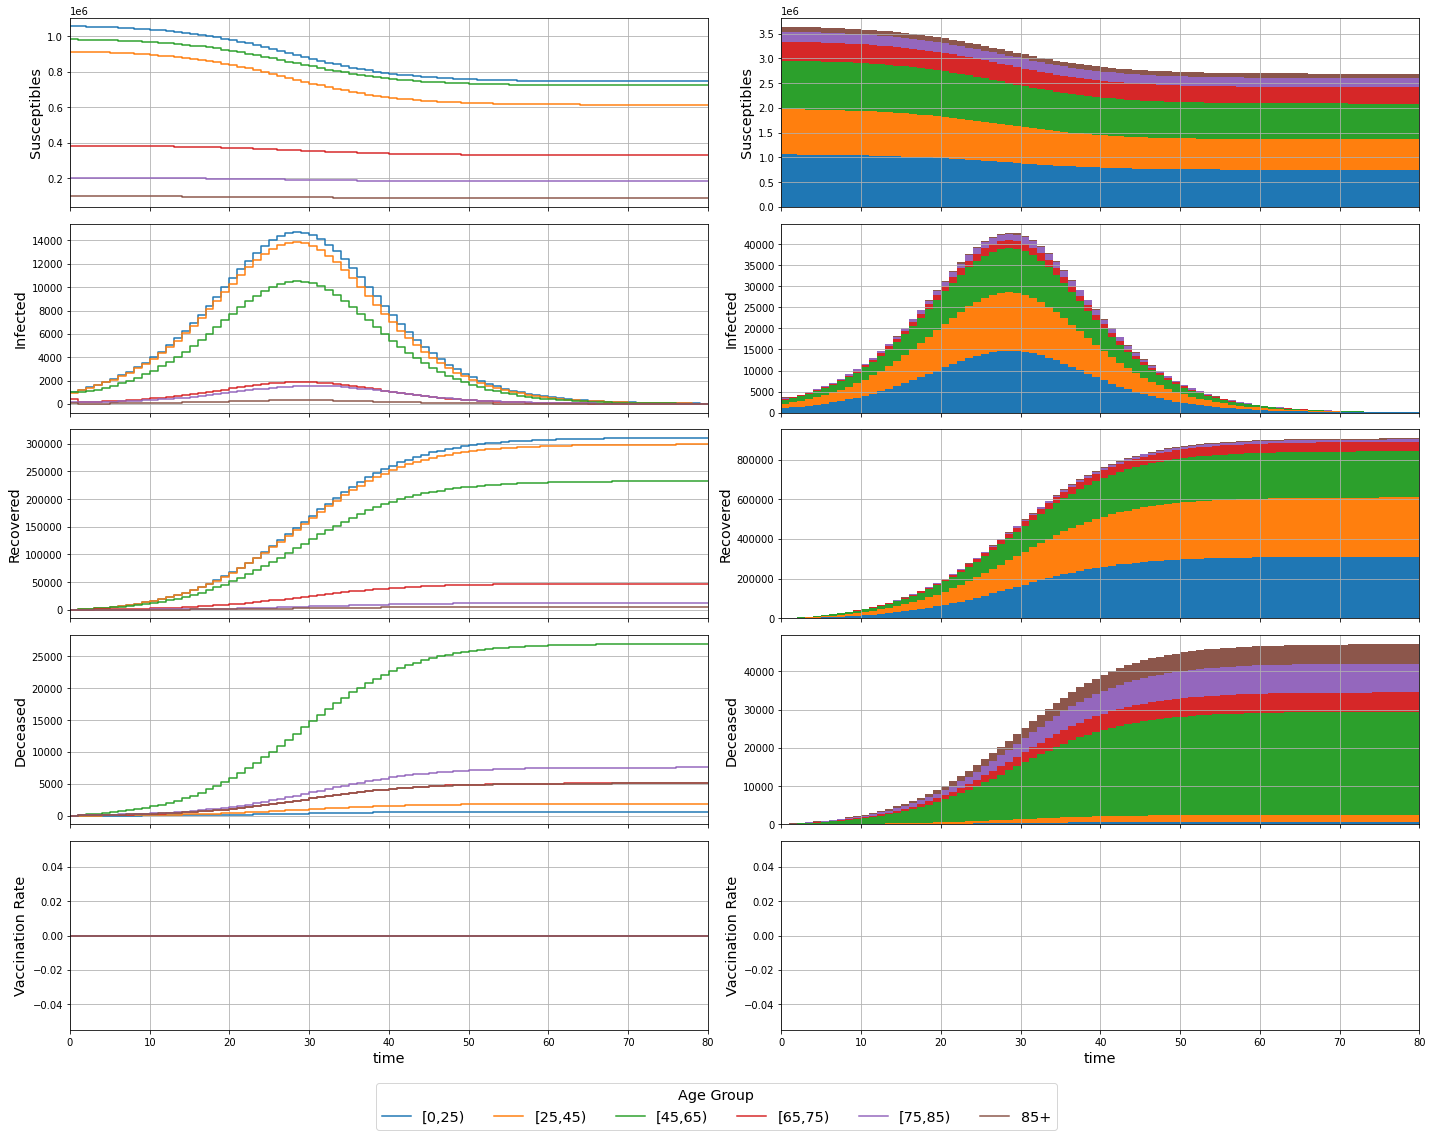

Deceased Total: 47115


In [7]:
def control(t, y, u_max):
  return np.zeros(n_a)

t, y = solve_ivp_discrete(system_discrete, t_span, y_0, args=(control, u_max, l, C, g_R, g_D))

S, I, R, D = unwrap(y)
u = recover_control(t, y, control, u_max)

plot(t, y, u, discrete=True)
print(f'Deceased Total: {sum(D[:,-1]):.0f}')

### Vaccination of Older Groups

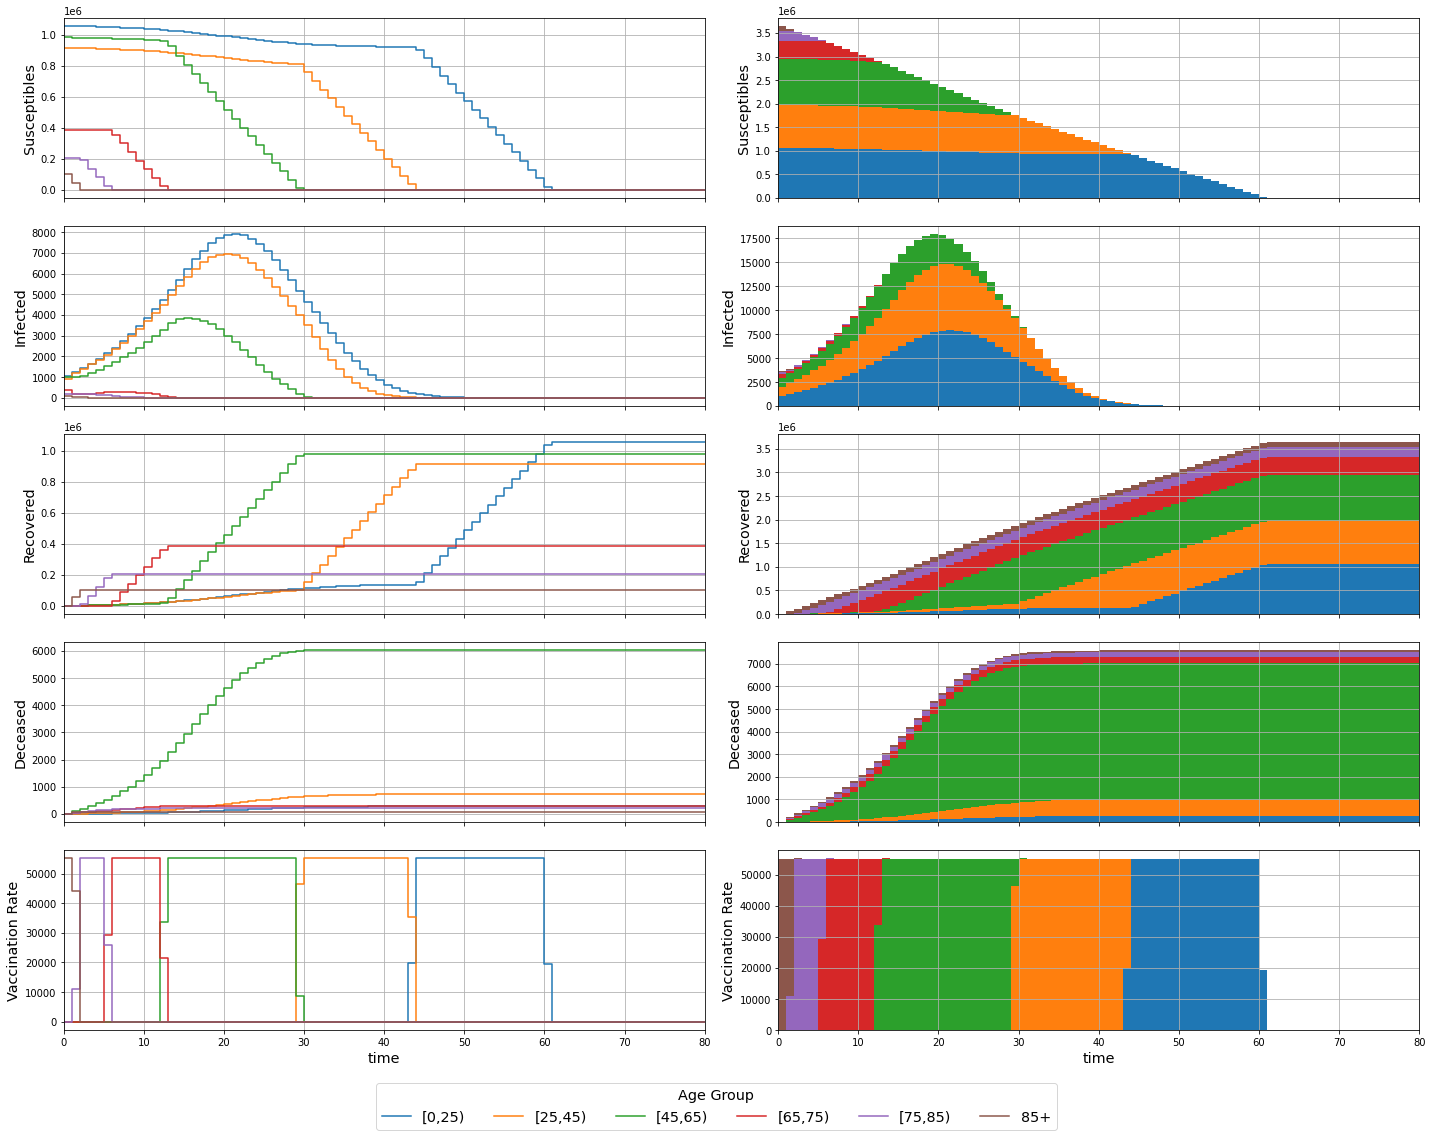

Deceased Total: 7593


In [8]:
def control(t, y, u_max):
  S, I, R, D = unwrap(y)
  u = np.zeros(n_a)
  remaining = u_max
  for i in reversed(range(n_a)):
    u[i] = min([S[i], remaining])
    remaining = remaining - u[i]
  return u

t, y = solve_ivp_discrete(system_discrete, t_span, y_0, args=(control, u_max, l, C, g_R, g_D))

S, I, R, D = unwrap(y)
u = recover_control(t, y, control, u_max)

plot(t, y, u, discrete=True)
print(f'Deceased Total: {sum(D[:,-1]):.0f}')

## MPC

### Definitions

In [9]:
import numpy as np
import casadi
from helpers import *

P, S_0, I_0, R_0, D_0, l, C, g_R, g_D, u_max = definitions()
X_0 = wrap(S_0, I_0, R_0, D_0)
n_a = len(P)

S = casadi.MX.sym('S', n_a)
I = casadi.MX.sym('I', n_a)
R = casadi.MX.sym('R', n_a)
D = casadi.MX.sym('D', n_a)
U = casadi.MX.sym('U', n_a)
X = wrap(S, I, R, D)

def system_discrete(X, U):
  S, I, R, D = unwrap(X)
  S_ = S - l * S * (C @ I) - U
  I_ = I + l * S * (C @ I) - (g_R + g_D) * I
  R_ = R + g_R * I + U
  D_ = D + g_D * I
  return wrap(S_, I_, R_, D_)

f = casadi.Function('f',[X, U],[system_discrete(X, U)],['X', 'U'],['X+'])
print(f)

f:(X[24],U[6])->(X+[24]) MXFunction


### Optimization


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   4.43ms (  7.32us)       606
       nlp_g  | 210.00ms (346.53us) 157.29ms (259.55us)       606
  nlp_grad_f  |   8.00ms ( 13.96us)  11.82ms ( 20.63us)       573
  nlp_hess_l  |   1.47 s (  2.57ms)   1.43 s (  2.50ms)       570
   nlp_jac_g  |   1.68 s (  2.93ms)   1.80 s (  3.13ms)       574
       total  |  28.03 s ( 28.03 s)  28.03 s ( 28.03 s)         1


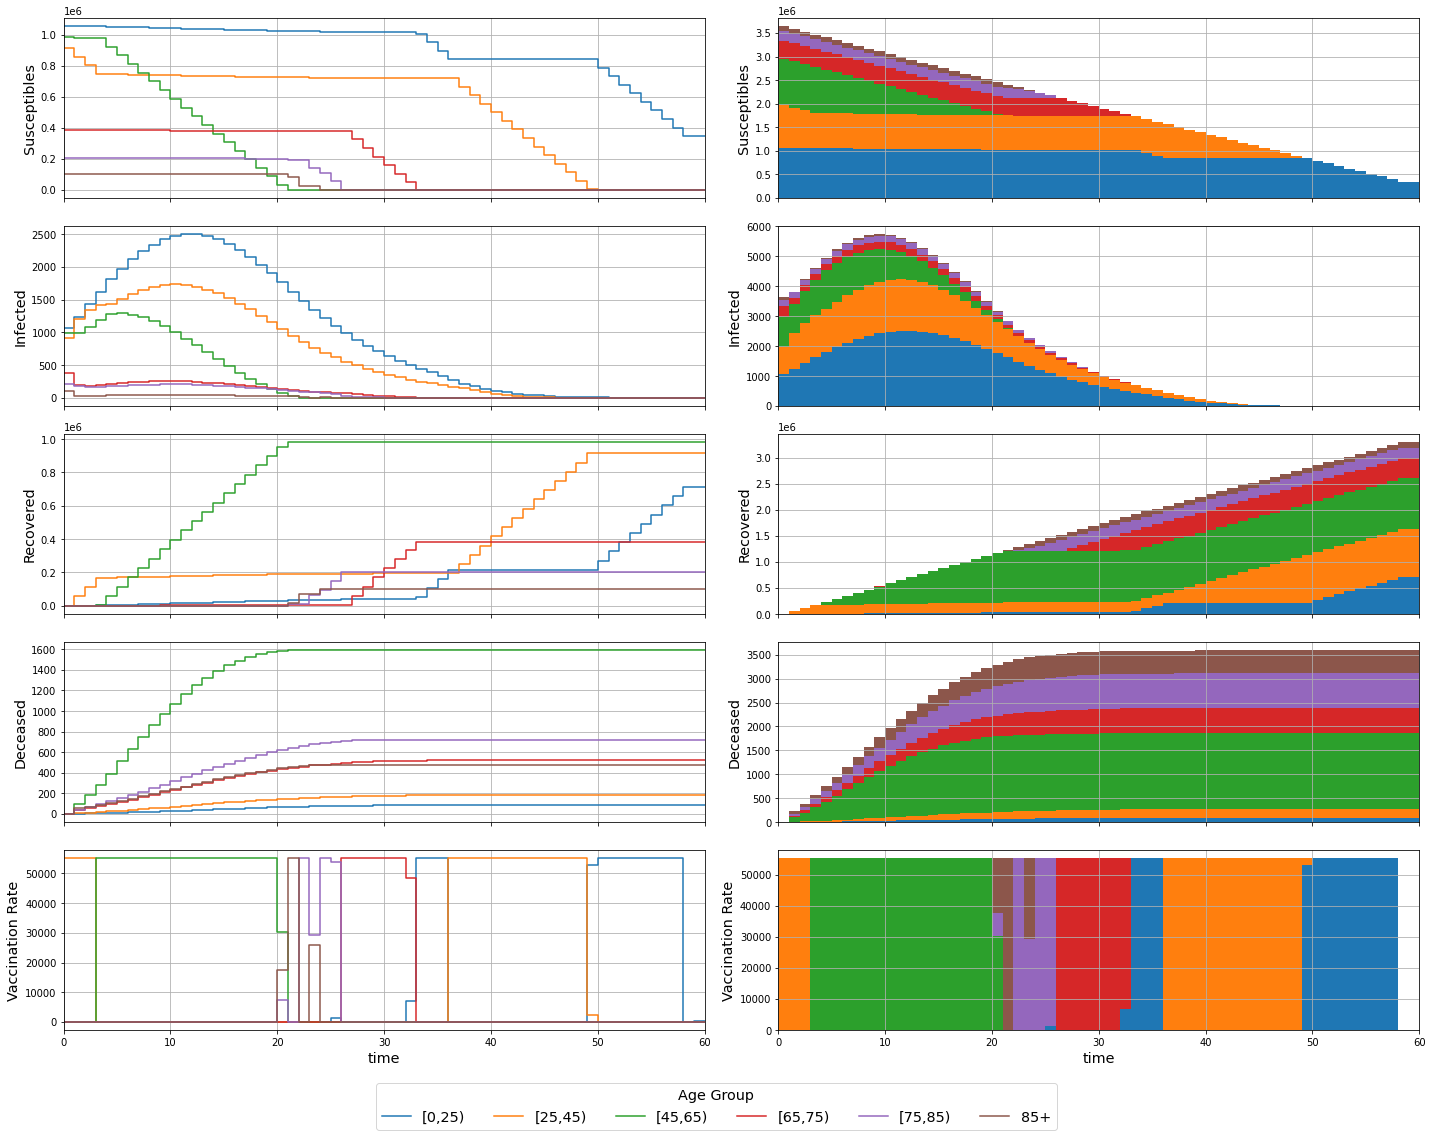

Deceased Total: 3590


In [10]:
opti = casadi.Opti()

N = 60 # prediction horizon

s = opti.variable(n_a, N + 1)
i = opti.variable(n_a, N + 1)
r = opti.variable(n_a, N + 1)
d = opti.variable(n_a, N + 1)
u = opti.variable(n_a, N)
x = wrap(s, i, r, d)

s_0 = opti.parameter(n_a,1)
i_0 = opti.parameter(n_a,1)
r_0 = opti.parameter(n_a,1)
d_0 = opti.parameter(n_a,1)
x_0 = wrap(s_0, i_0, r_0, d_0)

opti.minimize(0.1*casadi.sumsqr(i) + 0.9*casadi.sumsqr(d))

opti.subject_to(x[:,0] == x_0) # initial conditions
for k in range(N):
  opti.subject_to(x[:,k + 1] == f(x[:,k], u[:,k])) # dynamics
  opti.subject_to(u[:,k] <= s[:,k]) # dynamic control bound
opti.subject_to(opti.bounded(0,u,u_max)) # individual control bounds
opti.subject_to(opti.bounded(0,casadi.sum1(u),u_max)) # joint control bounds

opti.set_value(x_0, X_0)

opti.solver('ipopt', {}, {
  'print_level': 0,
})

sol = opti.solve()

t_grid = range(N + 1)
x_grid = sol.value(x)
u_grid = np.hstack((sol.value(u), np.nan*np.ones((n_a,1))))
plot(t_grid, x_grid, u_grid, discrete=True)

print(f'Deceased Total: {sum(x_grid[3*n_a:4*n_a,-1]):.0f}')

### MPC

M:(x_0[24])->(u[6]) MXFunction
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  13.00ms ( 21.45us)   4.83ms (  7.97us)       606
       nlp_g  | 172.00ms (283.83us) 166.29ms (274.40us)       606
  nlp_grad_f  |        0 (       0)  13.06ms ( 22.79us)       573
  nlp_hess_l  |   1.50 s (  2.63ms)   1.47 s (  2.59ms)       570
   nlp_jac_g  |   1.85 s (  3.22ms)   1.89 s (  3.29ms)       574
       total  |  31.26 s ( 31.26 s)  31.25 s ( 31.25 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  13.00ms ( 11.29us)   9.46ms (  8.22us)      1151
       nlp_g  | 416.00ms (361.42us) 327.05ms (284.14us)      1151
    nlp_grad  |        0 (       0) 561.00us (561.00us)         1
  nlp_grad_f  |   9.00ms (  8.19us)  25.88ms ( 23.55us)      1099
  nlp_hess_l  |   2.92 s (  2.67ms)   2.89 s (  2.64ms)      1094
   nlp_jac_g  |   3.62 s (  3.28ms)   3.74 s (  3.39ms)      1102
       total  |  31.08 s ( 31.08 s)  31.08 s 

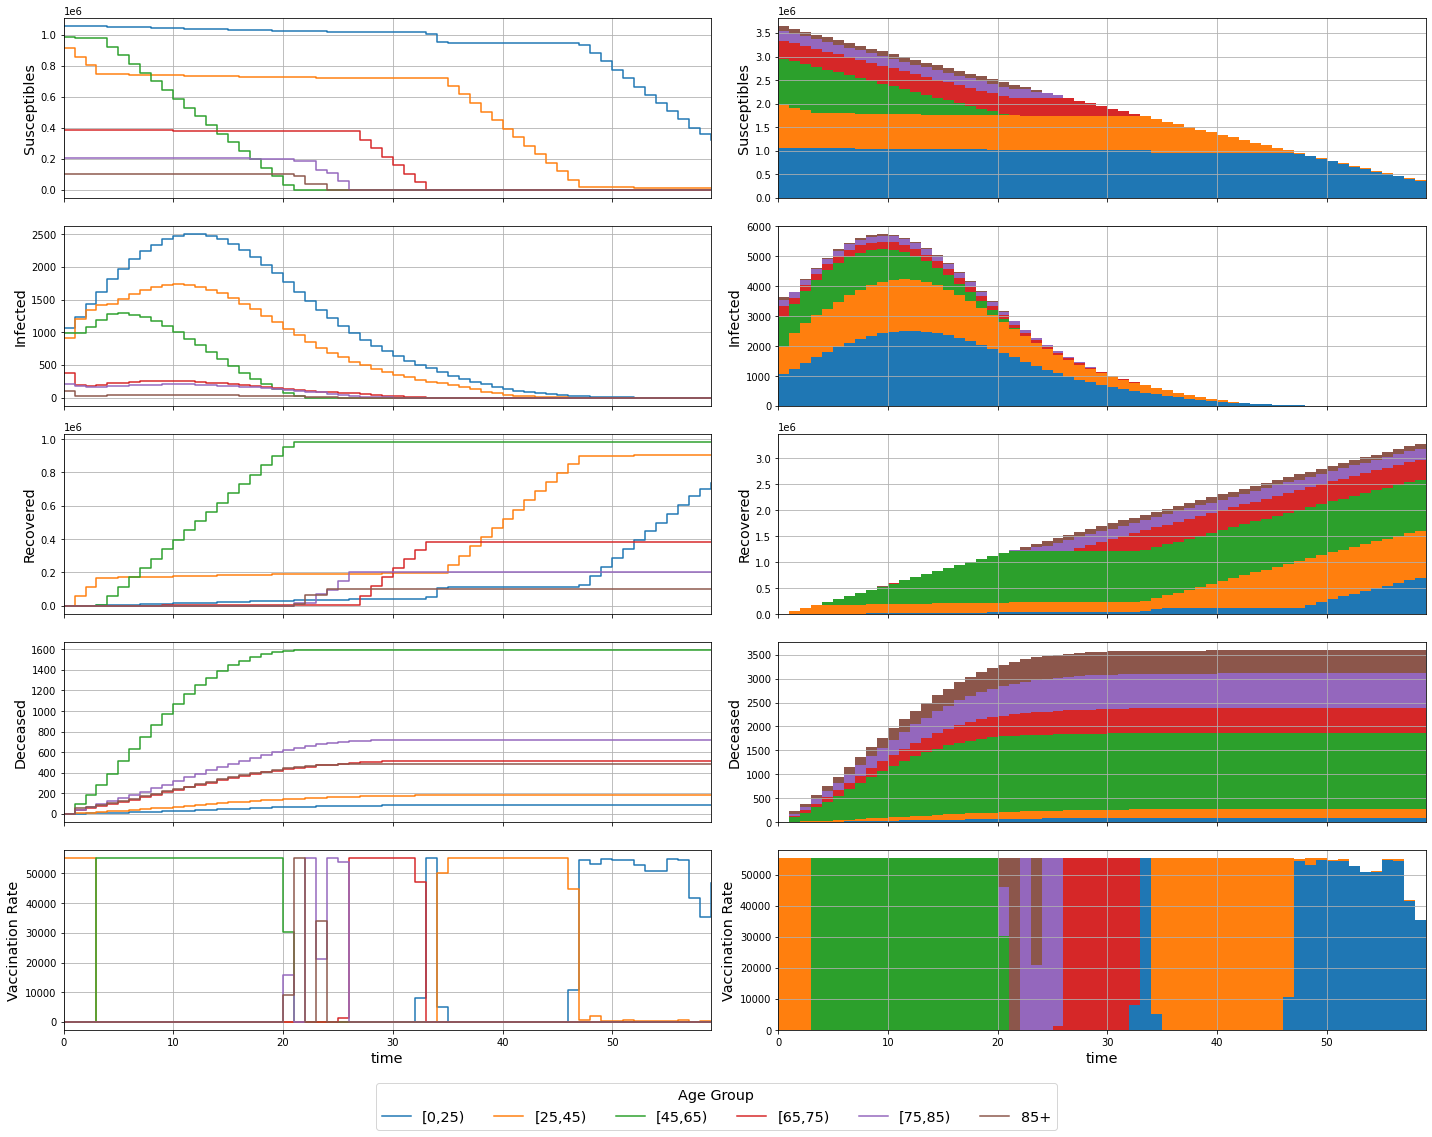

Deceased Total: 3591


In [11]:
O = opti.to_function('M',[x_0],[u[:,0]],['x_0'],['u'])
print(O)

M = 1 # control horizon [?]

x_ = X_0
x_log = np.empty((0, x_0.shape[0]))
u_log = np.empty((0, u.shape[0]))
for i in range(N):
  if i % M == 0:
    u_ = np.array(O(x_))[:,0]

  x_log = np.vstack((x_log, x_))
  u_log = np.vstack((u_log, u_))

  x_ = np.array(f(x_,u_))[:,0]

t_log = range(N)
x_log = x_log.T
u_log = u_log.T
plot(t_log, x_log, u_log, discrete=True)

print(f'Deceased Total: {sum(x_log[3*n_a:4*n_a,-1]):.0f}')